In [ ]:
pip install tensorflow matplotlib numpy

# **Importing libraries**

In [ ]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict, Counter

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# **Loading data and labelling**

In [ ]:
working_base = Path("/content/drive/MyDrive/Image_Dataset")
label_map = {
    "class1": "Laysan Albatross",
    "class2": "Red inged Blackbird",
    "class3": "Eastern Towhee",
    "class4": "White breasted Nuthatch",
    "class5": "American Pipit"
}
expected_labels = list(label_map.values())

# **Pre-processing**

In [ ]:
print("🔧 Preprocessing and standardizing images...")
for new_label in label_map.values():
    folder_path = working_base / new_label
    for idx, img_path in enumerate(sorted(folder_path.glob("*.tif"))):
        img = cv2.imread(str(img_path))  # BGR
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # to RGB

        # Histogram equalization per channel
        img = cv2.split(img)
        img = [cv2.equalizeHist(channel) for channel in img]
        img = cv2.merge(img)

        img = cv2.GaussianBlur(img, (5, 5), 0)
        img = cv2.resize(img, (224, 224))

        new_filename = f"{new_label}_{idx:05d}.tif"
        new_img_path = folder_path / new_filename
        cv2.imwrite(str(new_img_path), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

        if img_path.name != new_filename:
            img_path.unlink()

🔧 Preprocessing and standardizing images...


In [ ]:
label_map = {
    "002.Laysan_Albatross": "Laysan Albatross",
    "010.Red_winged_Blackbird": "Red inged Blackbird",
    "021.Eastern_Towhee": "Eastern Towhee",
    "094.White_breasted_Nuthatch": "White breasted Nuthatch",
    "104.American_Pipit": "American Pipit"
}

In [ ]:
if working_base.exists():
    shutil.rmtree(working_base)
shutil.copytree(original_base, working_base)

# RENAME FOLDERS
for old_folder_name, new_label in label_map.items():
    old_folder_path = working_base / old_folder_name
    new_folder_path = working_base / new_label

    if old_folder_path.exists():
        os.rename(old_folder_path, new_folder_path)
        print(f"Renamed {old_folder_path.name} → {new_label}")

Renamed 002.Laysan_Albatross → Laysan Albatross
Renamed 010.Red_winged_Blackbird → Red inged Blackbird
Renamed 021.Eastern_Towhee → Eastern Towhee
Renamed 094.White_breasted_Nuthatch → White breasted Nuthatch
Renamed 104.American_Pipit → American Pipit


In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [ ]:
for new_label in label_map.values():
    folder_path = working_base / new_label
    for idx, img_path in enumerate(sorted(folder_path.glob("*.jpg"))):
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = cv2.split(img)
        img = [cv2.equalizeHist(channel) for channel in img]
        img = cv2.merge(img)

        img = cv2.GaussianBlur(img, (5, 5), 0)
        img = cv2.resize(img, (224, 224))

        new_filename = f"{new_label}_{idx:05d}.jpg"
        new_img_path = folder_path / new_filename
        cv2.imwrite(str(new_img_path), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

        if img_path.name != new_filename:
            img_path.unlink()

In [ ]:
# VERIFY
expected_labels = set(label_map.values())
total_images = 0
errors = []

for label in expected_labels:
    folder = working_base / label
    for img_path in folder.glob("*.jpg"):
        total_images += 1
        if not img_path.name.startswith(label + "_"):
            errors.append(f"Wrong filename: {img_path.name}")
        img = cv2.imread(str(img_path))
        if img is None:
            errors.append(f"Unreadable image: {img_path.name}")
            continue
        if img.shape != (224, 224, 3):
            errors.append(f"Wrong shape {img.shape} in: {img_path.name}")

print(f"\nVerified {total_images} images.")
if errors:
    print(f"Found {len(errors)} issue(s):")
    for err in errors[:10]:
        print(" -", err)
    if len(errors) > 10:
        print("... more issues omitted.")
else:
    print("All images verified successfully!")


Verified 300 images.
All images verified successfully!



Displaying sample images from each class...


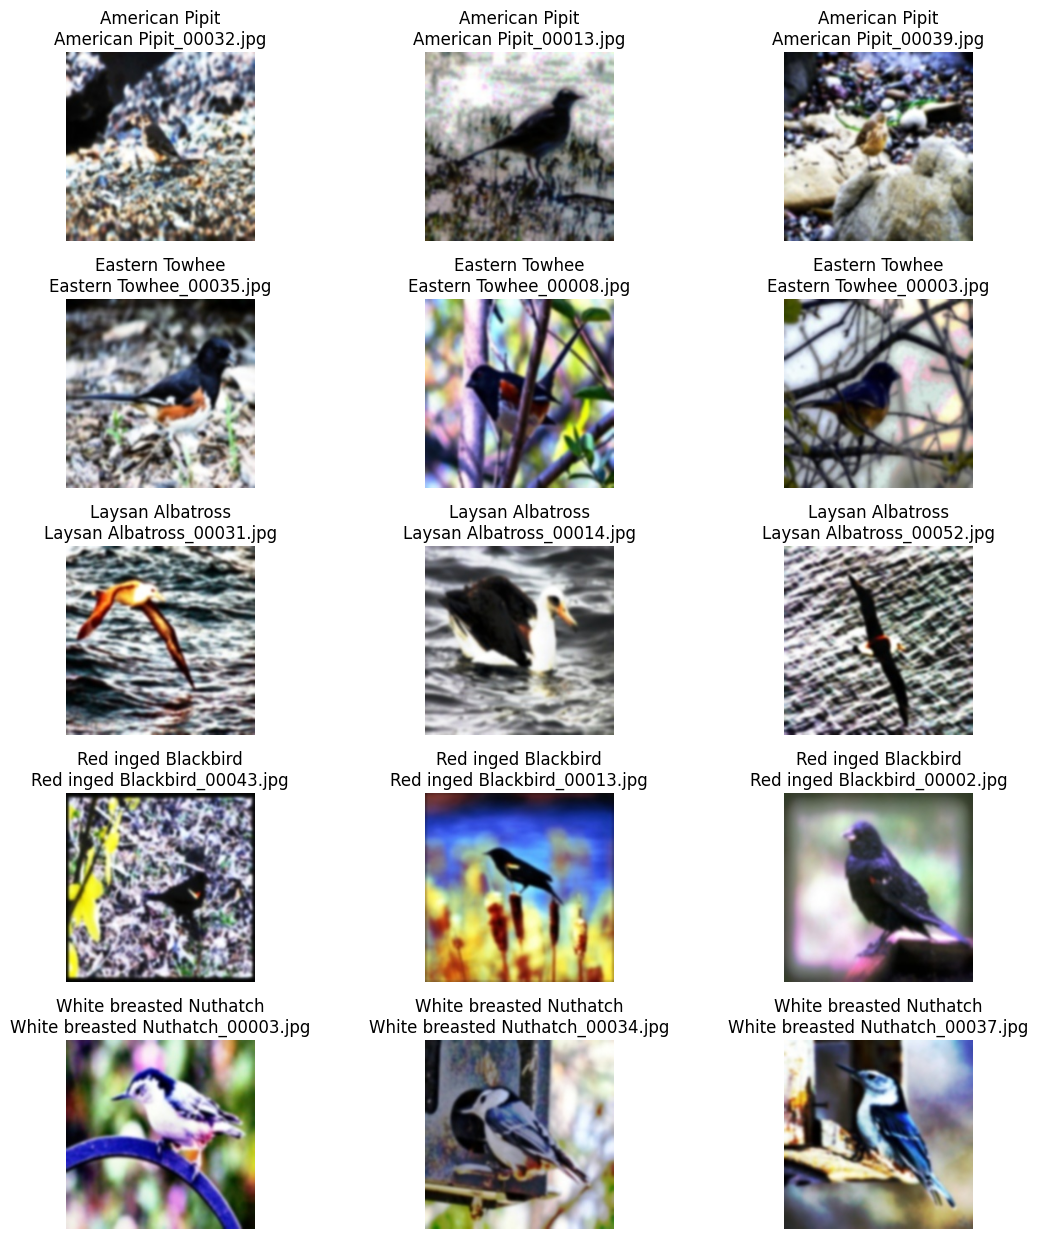

In [ ]:
print("\nDisplaying sample images from each class...")
samples_per_class = 3
fig, axs = plt.subplots(len(expected_labels), samples_per_class, figsize=(12, 2.5 * len(expected_labels)))

for i, label in enumerate(sorted(expected_labels)):
    folder = working_base / label
    all_images = list(folder.glob("*.jpg"))
    sample_images = random.sample(all_images, min(samples_per_class, len(all_images)))
    for j, img_path in enumerate(sample_images):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        axs[i, j].set_title(f"{label}\n{img_path.name}")

plt.tight_layout()
plt.show()

In [ ]:
class_names = sorted([f.name for f in working_base.iterdir() if f.is_dir()])
print("Classes present in the dataset:")
print(class_names)


Classes present in the dataset:
['American Pipit', 'Eastern Towhee', 'Laysan Albatross', 'Red inged Blackbird', 'White breasted Nuthatch']


In [ ]:
print("\n Image Size and Pixel Intensity Stats")

image_shapes = defaultdict(int)
channel_means = []
channel_stds = []
aspect_ratios = []

for label in class_names:
    folder = working_base / label
    for img_path in folder.glob("*.jpg"):
        img = cv2.imread(str(img_path))
        if img is None:
            continue

        h, w, c = img.shape
        image_shapes[(h, w)] += 1
        aspect_ratios.append(w / h)

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
        channel_means.append(np.mean(img_rgb, axis=(0, 1)))
        channel_stds.append(np.std(img_rgb, axis=(0, 1)))


 Image Size and Pixel Intensity Stats


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


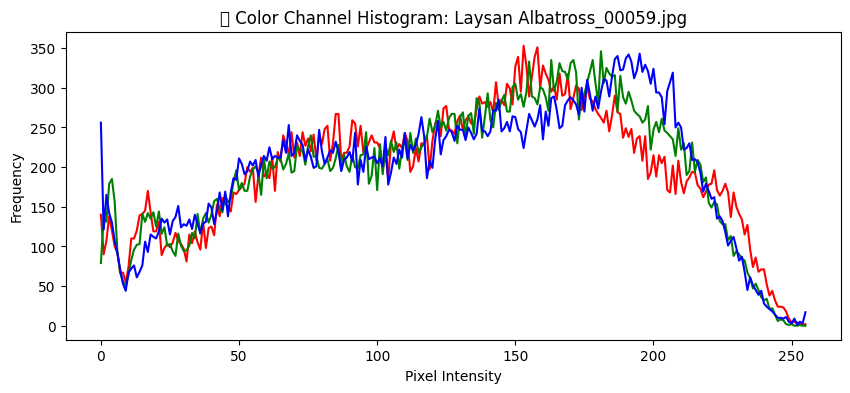

In [ ]:
import random

random_label = random.choice(class_names)
random_img_path = random.choice(list((working_base / random_label).glob("*.jpg")))
img = cv2.imread(str(random_img_path))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

colors = ['r', 'g', 'b']
plt.figure(figsize=(10, 4))
for i, color in enumerate(colors):
    hist = cv2.calcHist([img_rgb], [i], None, [256], [0, 256])
    plt.plot(hist, color=color)
plt.title(f"📈 Color Channel Histogram: {random_img_path.name}")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

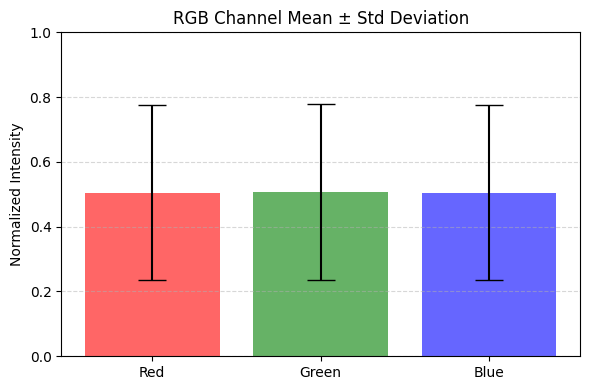

In [ ]:
channel_means = np.array(channel_means)
channel_stds = np.array(channel_stds)

mean_vals = channel_means.mean(axis=0)
std_vals = channel_stds.mean(axis=0)
channels = ['Red', 'Green', 'Blue']

plt.figure(figsize=(6, 4))
plt.bar(channels, mean_vals, yerr=std_vals, capsize=10, color=['red', 'green', 'blue'], alpha=0.6)
plt.ylabel("Normalized Intensity")
plt.title("RGB Channel Mean ± Std Deviation")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# **Pie chart for images per class**

/tmp/ipython-input-40-2709552918.py:17: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


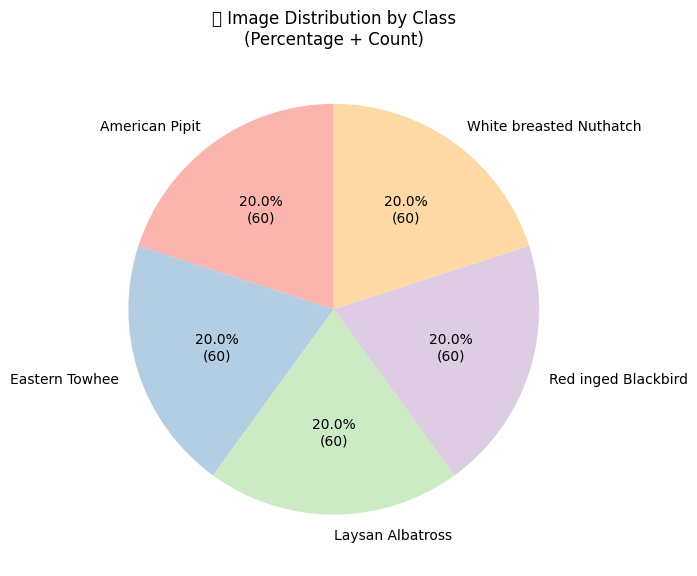

In [ ]:
import matplotlib.pyplot as plt

def autopct_format(pct, all_vals):
    absolute = int(round(pct / 100 * sum(all_vals)))
    return f"{pct:.1f}%\n({absolute})"

plt.figure(figsize=(7, 7))
plt.pie(
    class_counts.values(),
    labels=class_counts.keys(),
    autopct=lambda pct: autopct_format(pct, list(class_counts.values())),
    startangle=90,
    colors=plt.cm.Pastel1.colors[:len(class_counts)]
)
plt.title("📊 Image Distribution by Class\n(Percentage + Count)")
plt.tight_layout()
plt.show()
